In [1]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
import torchvision.utils as tvutils

from my_utils.vis import *
from my_utils import models
from my_utils.utils import check_accuracy
from my_utils.data.dataset import MyDataset


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots

# life save magic code
%load_ext autoreload
%autoreload 2

In [2]:
print(f"torch version: {torch.__version__}")
use_cuda = torch.cuda.is_available()
if use_cuda:
    GPU_nums = torch.cuda.device_count()
    GPU = torch.cuda.get_device_properties(0)
    print(f"There are {GPU_nums} GPUs in total.\nThe first GPU is: {GPU}")
    if '3060' in GPU.name:
        print(f"CUDA version: {torch.cuda_version}")
    else:
        print(f"CUDA version: {torch.version.cuda}")
device = torch.device(f"cuda:3" if use_cuda else "cpu")
print(f"Using {device} now!")

torch version: 1.10.2+cu113
There are 8 GPUs in total.
The first GPU is: _CudaDeviceProperties(name='Tesla V100-SXM2-32GB', major=7, minor=0, total_memory=32510MB, multi_processor_count=80)
CUDA version: 11.3
Using cuda:3 now!


In [3]:
T = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 64)),
])

In [9]:
dataset = MyDataset(
    dataset_root='/mnt/cfs/wangyh/blender/blank_wall/raw_pngs/variety/',
    reduce_mode='H',
    transform=T,
    mat_name='NNone',
    cls_mode='position'
)
loader = DataLoader(dataset, batch_size=64, shuffle=False)
len(loader.dataset)
# print(unseen_loader.dataset[0][0].shape)

Loading dataset:


100%|████████████████████████████████████████████████████| 849/849 [00:05<00:00, 162.37it/s]


800

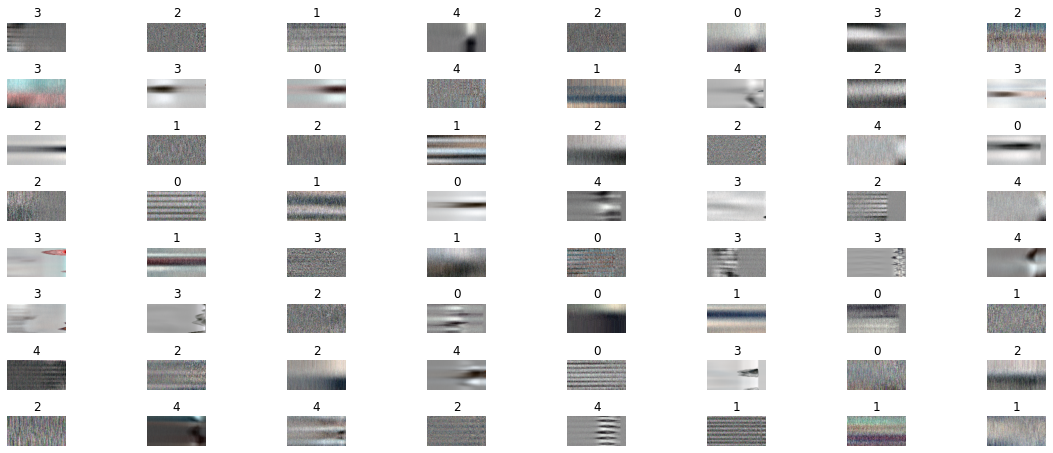

In [10]:
grid_vis(loader, row_num=8, multiply=5)

In [11]:
model = models.NLOS_Conv(num_classes=5, depths=(4,1), dims=(8, 16), kernel_size=7).to(device)
run_dir = '/home/wangyh/01-Projects/01-NLOS/test_runs/2022_05_30_22_59_15'
checkpoint = torch.load(os.path.join(run_dir, 'checkpoints/best.pth'))
print('best val acc is:', checkpoint['best_val_acc'].item())
new_state_dict = {k.replace('module.',''):v for k,v in checkpoint['model'].items()}
model.load_state_dict(new_state_dict)

best val acc is: 0.4937500059604645


<All keys matched successfully>

In [12]:
m = check_accuracy(model, loader)

13it [00:02,  4.65it/s]

Test accuracy is : 51.62%	Infer time: 2.7988173961639404


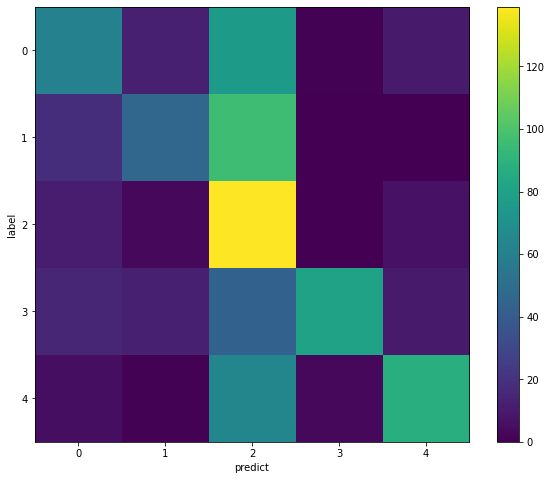

In [13]:
plt.imshow(m, cmap='viridis')
plt.ylabel('label')
plt.xlabel('predict')
plt.colorbar()
plt.show()

In [33]:
'' in 'HW'

True